In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
unvotes = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/unvotes.csv")
roll_calls = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/roll_calls.csv")
issues = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2021/2021-03-23/issues.csv")

print(unvotes.head())
print(roll_calls.head())
print(issues.head())

   rcid             country country_code vote
0     3       United States           US  yes
1     3              Canada           CA   no
2     3                Cuba           CU  yes
3     3               Haiti           HT  yes
4     3  Dominican Republic           DO  yes
   rcid  session  importantvote        date    unres  amend  para  \
0     3        1            0.0  1946-01-01   R/1/66    1.0   0.0   
1     4        1            0.0  1946-01-02   R/1/79    0.0   0.0   
2     5        1            0.0  1946-01-04   R/1/98    0.0   0.0   
3     6        1            0.0  1946-01-04  R/1/107    0.0   0.0   
4     7        1            0.0  1946-01-02  R/1/295    1.0   0.0   

                            short  \
0  AMENDMENTS, RULES OF PROCEDURE   
1      SECURITY COUNCIL ELECTIONS   
2                VOTING PROCEDURE   
3     DECLARATION OF HUMAN RIGHTS   
4      GENERAL ASSEMBLY ELECTIONS   

                                               descr  
0  TO ADOPT A CUBAN AMENDMENT T

In [3]:
print("UN Votes dataset shape:", unvotes.shape)
print("Issues dataset shape:", issues.shape)
print("Roll Calls dataset shape:", roll_calls.shape)

UN Votes dataset shape: (869937, 4)
Issues dataset shape: (5745, 3)
Roll Calls dataset shape: (6202, 9)


Merge inner

In [ ]:
# df = unvotes.merge(roll_calls, on="rcid").merge(issues, on="rcid")
# df.shape

# print("Merged dataset shape:", df.shape)
# print("\nColumns in merged dataset:")
# print(df.columns.tolist())
# print(df.head())

Merged dataset shape: (857878, 14)

Columns in merged dataset:
['rcid', 'country', 'country_code', 'vote', 'session', 'importantvote', 'date', 'unres', 'amend', 'para', 'short', 'descr', 'short_name', 'issue']
   rcid             country country_code     vote  session  importantvote  \
0     6       United States           US       no        1            0.0   
1     6              Canada           CA       no        1            0.0   
2     6                Cuba           CU      yes        1            0.0   
3     6  Dominican Republic           DO  abstain        1            0.0   
4     6              Mexico           MX      yes        1            0.0   

         date    unres  amend  para                        short  \
0  1946-01-04  R/1/107    0.0   0.0  DECLARATION OF HUMAN RIGHTS   
1  1946-01-04  R/1/107    0.0   0.0  DECLARATION OF HUMAN RIGHTS   
2  1946-01-04  R/1/107    0.0   0.0  DECLARATION OF HUMAN RIGHTS   
3  1946-01-04  R/1/107    0.0   0.0  DECLARATION OF HUM

In [ ]:
# Merge the datasets
df = unvotes.merge(roll_calls, on='rcid', how='left')
df = df.merge(issues, on='rcid', how='left')

print("Merged dataset shape:", df.shape)
print("\nColumns in merged dataset:")
print(df.columns.tolist())
print(df.head())

Merged dataset shape: (1123334, 14)

Columns in merged dataset:
['rcid', 'country', 'country_code', 'vote', 'session', 'importantvote', 'date', 'unres', 'amend', 'para', 'short', 'descr', 'short_name', 'issue']
         rcid             country country_code vote  session  importantvote  \
0           3       United States           US  yes        1            0.0   
1           3              Canada           CA   no        1            0.0   
2           3                Cuba           CU  yes        1            0.0   
3           3               Haiti           HT  yes        1            0.0   
4           3  Dominican Republic           DO  yes        1            0.0   
...       ...                 ...          ...  ...      ...            ...   
1123329  9101           Venezuela           VE  yes       74            NaN   
1123330  9101             Vietnam           VN  yes       74            NaN   
1123331  9101               Yemen           YE  yes       74            NaN   

In [22]:
df['date'] = pd.to_datetime(df['date'])

# Extract year for temporal analysis
df['year'] = df['date'].dt.year

# Create a decade column for broader temporal analysis
df['decade'] = (df['year'] // 10) * 10

# Clean vote types - group similar categories
df['vote'] = df['vote'].map({'yes': 'Yes', 'no': 'No', 'abstain': 'Abstain', 
                            'not a member': 'Not Member', 'absent': 'Absent'})

# Handle missing values in issue column
df['issue'] = df['issue'].fillna('Other')

print("Date range:", df['date'].min(), "to", df['date'].max())
print("Number of countries:", df['country'].nunique())
print("Number of resolutions:", df['rcid'].nunique())

Date range: 1946-01-01 00:00:00 to 2019-12-27 00:00:00
Number of countries: 200
Number of resolutions: 6202


In [26]:
# Summary statistics
print("Vote Distribution:")
vote_counts = df['vote'].value_counts()
print(vote_counts)

print("\nIssue Distribution:")
issue_counts = df['issue'].value_counts()
print(issue_counts)

print(f"\nTotal votes in dataset: {len(df):,}")
print(f"Time span: {df['year'].min()} to {df['year'].max()} ({df['year'].max() - df['year'].min()} years)")
print(f"Number of unique countries: {df['country'].nunique()}")

Vote Distribution:
vote
Yes        898190
Abstain    144146
No          80998
Name: count, dtype: int64

Issue Distribution:
issue
Other                                   265456
Arms control and disarmament            170497
Palestinian conflict                    158656
Human rights                            156623
Nuclear weapons and nuclear material    133635
Colonialism                             129708
Economic development                    108759
Name: count, dtype: int64

Total votes in dataset: 1,123,334
Time span: 1946 to 2019 (73 years)
Number of unique countries: 200


In [24]:
# Define key countries and regions for analysis
major_powers = ['United States', 'China', 'Russia', 'United Kingdom', 'France', 
                'India', 'Germany', 'Japan', 'Brazil', 'South Africa']

# Regional groupings
european_countries = ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Netherlands', 'Sweden']
asian_countries = ['China', 'Japan', 'India', 'South Korea', 'Indonesia', 'Pakistan']
middle_east = ['Saudi Arabia', 'Iran', 'Israel', 'Egypt', 'Turkey']
african_countries = ['South Africa', 'Nigeria', 'Egypt', 'Kenya', 'Ethiopia']
latin_america = ['Brazil', 'Argentina', 'Mexico', 'Chile', 'Colombia']


## Visualization 1: Voting Alignment with Major Powers Over Time

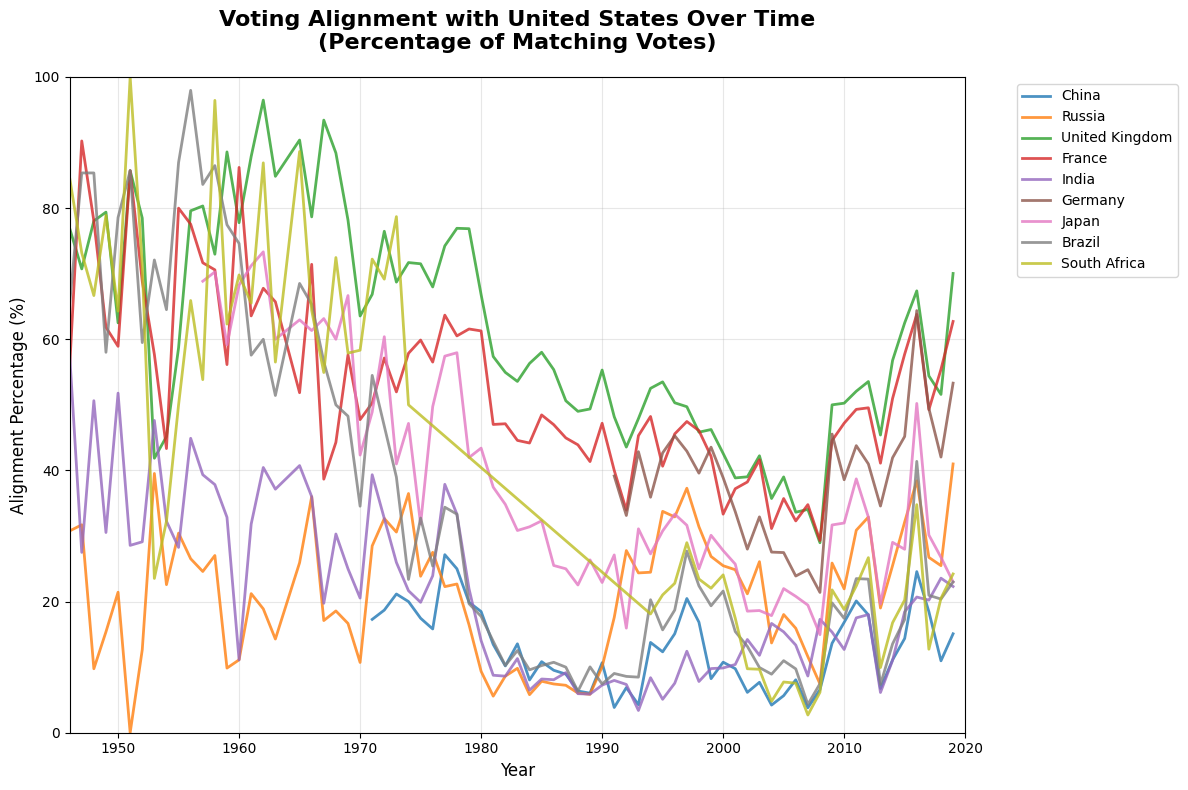

In [25]:
# Calculate voting alignment with key countries over time
def calculate_alignment(country1, country2, df):
    """Calculate voting alignment between two countries"""
    # Get common resolutions
    country1_votes = df[df['country'] == country1][['rcid', 'vote']].rename(columns={'vote': 'vote1'})
    country2_votes = df[df['country'] == country2][['rcid', 'vote']].rename(columns={'vote': 'vote2'})
    
    merged = country1_votes.merge(country2_votes, on='rcid')
    
    # Calculate alignment (same vote = aligned)
    merged['aligned'] = merged['vote1'] == merged['vote2']
    merged['year'] = merged['rcid'].map(df.drop_duplicates('rcid').set_index('rcid')['year'])
    
    return merged

# Calculate alignment with US for major powers
alignment_data = []
for country in major_powers:
    if country != 'United States':
        alignment_df = calculate_alignment('United States', country, df)
        yearly_alignment = alignment_df.groupby('year')['aligned'].mean().reset_index()
        yearly_alignment['country'] = country
        alignment_data.append(yearly_alignment)

alignment_df = pd.concat(alignment_data, ignore_index=True)

# Create the visualization
plt.figure(figsize=(12, 8))
for country in alignment_df['country'].unique():
    country_data = alignment_df[alignment_df['country'] == country]
    plt.plot(country_data['year'], country_data['aligned'] * 100, 
             label=country, linewidth=2, alpha=0.8)

plt.title('Voting Alignment with United States Over Time\n(Percentage of Matching Votes)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Alignment Percentage (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(1946, 2020)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Explanation: This line chart shows how voting alignment with the United States has evolved for major world powers since 1946. Line charts are ideal for showing trends over time, allowing us to observe geopolitical shifts, such as the end of the Cold War or changes in bilateral relationships.

## Visualization 2: Regional Voting Patterns by Issue Area

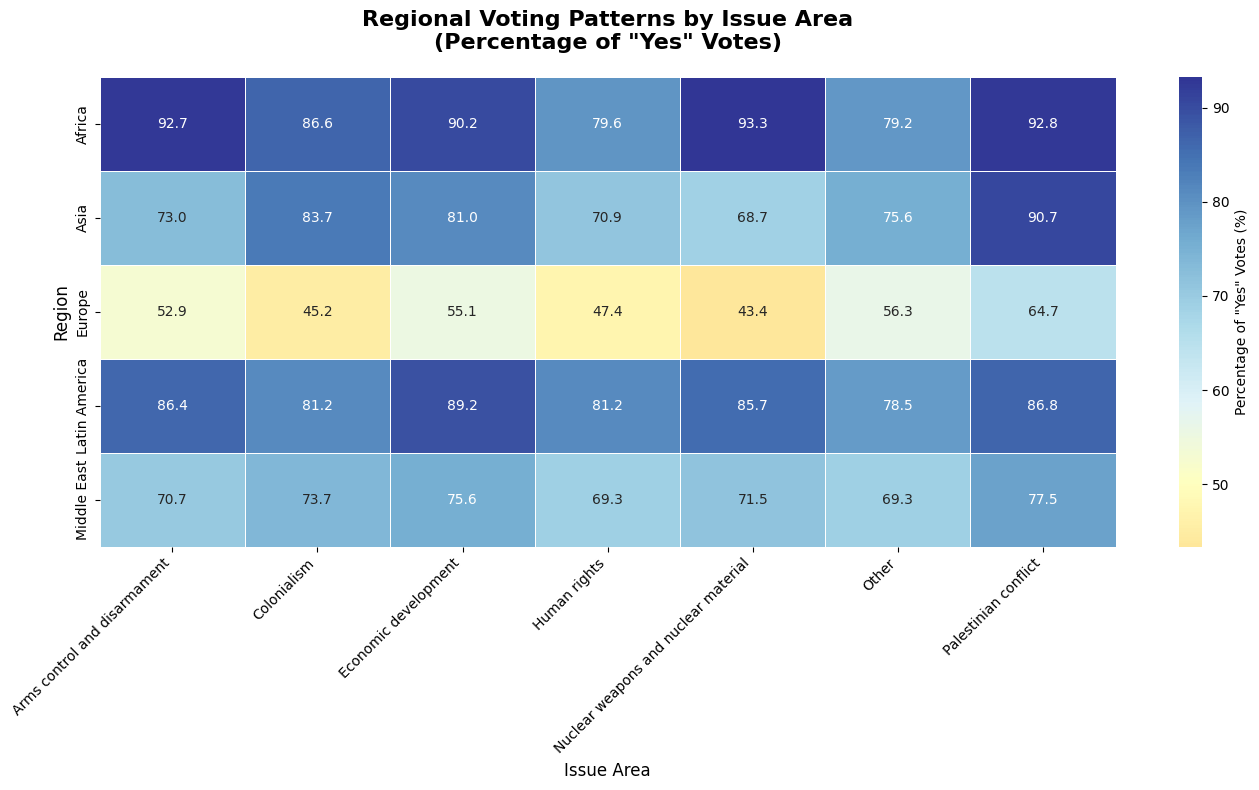

In [27]:
# Create regional analysis
def assign_region(country):
    if country in european_countries:
        return 'Europe'
    elif country in asian_countries:
        return 'Asia'
    elif country in middle_east:
        return 'Middle East'
    elif country in african_countries:
        return 'Africa'
    elif country in latin_america:
        return 'Latin America'
    else:
        return 'Other'

# Apply region assignment
regional_df = df[df['country'].isin(
    european_countries + asian_countries + middle_east + african_countries + latin_america
)].copy()
regional_df['region'] = regional_df['country'].apply(assign_region)

# Calculate regional voting patterns by issue
regional_issue_votes = regional_df.groupby(['region', 'issue', 'vote']).size().reset_index(name='count')
total_votes_by_region_issue = regional_issue_votes.groupby(['region', 'issue'])['count'].transform('sum')
regional_issue_votes['percentage'] = (regional_issue_votes['count'] / total_votes_by_region_issue) * 100

# Focus on 'Yes' votes for comparison
yes_votes = regional_issue_votes[regional_issue_votes['vote'] == 'Yes']

# Create heatmap data
heatmap_data = yes_votes.pivot_table(index='region', columns='issue', values='percentage', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlBu', center=50, 
            fmt='.1f', linewidths=0.5, cbar_kws={'label': 'Percentage of "Yes" Votes (%)'})
plt.title('Regional Voting Patterns by Issue Area\n(Percentage of "Yes" Votes)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Issue Area', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Explanation: This heatmap visualization shows regional voting patterns across different issue areas. Heatmaps are excellent for comparing multiple categories across two dimensions, making it easy to identify which regions are most supportive of different types of resolutions and revealing regional priorities.

## Visualization 3: Evolution of Consensus in UN Voting

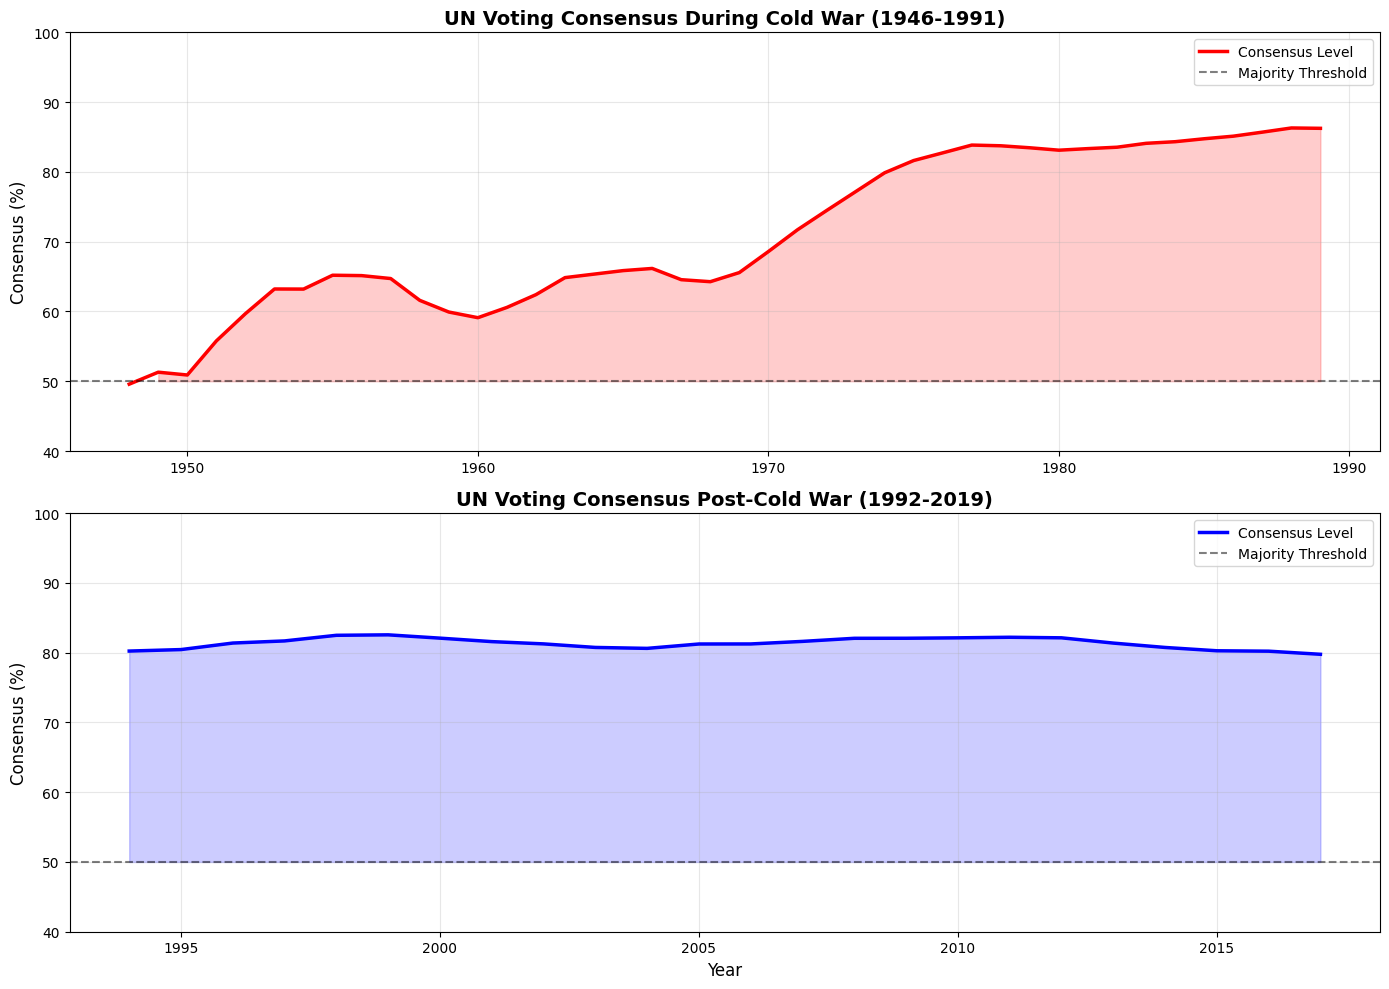

In [28]:
# Calculate consensus over time
def calculate_consensus(df, window=5):
    """Calculate voting consensus using rolling average"""
    yearly_votes = df.groupby(['year', 'vote']).size().unstack(fill_value=0)
    
    # Calculate percentage of most common vote
    total_votes = yearly_votes.sum(axis=1)
    max_votes = yearly_votes.max(axis=1)
    consensus = (max_votes / total_votes) * 100
    
    # Apply rolling average for smoothing
    consensus_smooth = consensus.rolling(window=window, center=True).mean()
    
    return consensus_smooth

# Calculate consensus for different periods
cold_war_period = df[(df['year'] >= 1946) & (df['year'] <= 1991)]
post_cold_war = df[(df['year'] >= 1992)]

cold_war_consensus = calculate_consensus(cold_war_period)
post_cold_war_consensus = calculate_consensus(post_cold_war)

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Cold War period
ax1.plot(cold_war_consensus.index, cold_war_consensus.values, 
         color='red', linewidth=2.5, label='Consensus Level')
ax1.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Majority Threshold')
ax1.fill_between(cold_war_consensus.index, cold_war_consensus.values, 50, 
                 where=(cold_war_consensus.values >= 50), color='red', alpha=0.2)
ax1.set_title('UN Voting Consensus During Cold War (1946-1991)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Consensus (%)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(40, 100)

# Post-Cold War period
ax2.plot(post_cold_war_consensus.index, post_cold_war_consensus.values, 
         color='blue', linewidth=2.5, label='Consensus Level')
ax2.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Majority Threshold')
ax2.fill_between(post_cold_war_consensus.index, post_cold_war_consensus.values, 50, 
                 where=(post_cold_war_consensus.values >= 50), color='blue', alpha=0.2)
ax2.set_title('UN Voting Consensus Post-Cold War (1992-2019)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Consensus (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(40, 100)

plt.tight_layout()
plt.show()

Explanation: This dual time series plot shows the evolution of consensus in UN voting, separated into Cold War and post-Cold War periods. Time series are perfect for showing long-term trends, while the dual-panel design allows for clear comparison between historical eras, highlighting how geopolitical contexts affect diplomatic cooperation.



# Discussion

## Figure 1 Discussion: Geopolitical Realignment
The voting alignment chart reveals significant geopolitical shifts over time. Russia (and previously the Soviet Union) shows the expected low alignment with the US during the Cold War, with a brief period of increased alignment in the early 1990s followed by divergence. China's alignment has fluctuated but generally remained low, reflecting its independent foreign policy. European allies like the UK and France show consistently high alignment, though with some variation. Interestingly, countries like India show changing patterns that reflect their non-aligned movement heritage and evolving global positioning.

## Figure 2 Discussion: Regional Priorities
The heatmap reveals clear regional patterns in voting behavior. European countries show strong support across most issue areas, particularly on human rights and colonialism. African nations show higher support for Palestinian-related resolutions, reflecting regional solidarity. Asian countries demonstrate varied patterns, with higher support for economic resolutions. The Middle East shows distinct voting patterns, particularly on nuclear and arms control issues. These patterns reflect regional priorities, historical contexts, and geopolitical considerations.

## Figure 3 Discussion: Changing Consensus
The consensus analysis shows that UN voting patterns have evolved significantly. During the Cold War, consensus levels were generally lower and more volatile, reflecting bipolar world politics. The post-Cold War era shows generally higher and more stable consensus, particularly in the 1990s and early 2000s, suggesting increased international cooperation. However, recent years show some decline in consensus, possibly reflecting emerging multipolar dynamics and new global challenges.